# Split pipeline

In [1]:
import polars as pl

from nebula.base import Transformer
from nebula.transformers import *
from nebula.storage import nebula_storage as ns
from nebula.pipelines.pipeline import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline

%load_ext autoreload
%autoreload 2

In [2]:
data = [
    [0.1234, "a", "b"],
    [4.1234, "", ""],
    [5.1234, None, None],
    [6.1234, "", None],
    [8.1234, "a", None],
    [9.1234, "a", ""],
    [10.1234, "", "b"],
    [11.1234, "a", None],
    [12.1234, None, "b"],
    [14.1234, "", None],
]

df_input = pl.DataFrame(data, orient="row", schema=["c1", "c2", "c3"])
print(df_input.schema)
df_input

Schema([('c1', Float64), ('c2', String), ('c3', String)])


c1,c2,c3
f64,str,str
0.1234,"""a""","""b"""
4.1234,"""""",""""""
5.1234,null,null
6.1234,"""""",null
8.1234,"""a""",null
9.1234,"""a""",""""""
10.1234,"""""","""b"""
11.1234,"""a""",null
12.1234,null,"""b"""


## Create a split pipeline using python
Two splits:
- The first one, `low`, with 2 transformers `RoundValues` and `Cast`
- The second one, `hi`, with 2 transformers `RoundValues` and `Cast`

The split-function `my_split_function` takes the input dataframe, divide it into two separate dataframes based on the values in the `c1` column, placing those `< 10` in one dataframe and those `>= 10` in another one. Then it returns the two dataframes in a dictionary with the keys `low` and `hi`.

In [3]:
def my_split_function(df):
    cond = pl.col("c1") < 10
    return {
        "low": df.filter(cond),
        "hi": df.filter(~cond),
    }


class RoundValues(Transformer):

    def __init__(self, *, column: str, precision: int):
        super().__init__()
        self._col = column
        self._precision = precision

    def _transform_polars(self, df):
        return df.with_columns(
            pl.col(self._col).round(self._precision).alias(self._col)
        )

def empty_strings_to_null(df: pl.DataFrame) -> pl.DataFrame:
    """Convert empty strings to null for all string columns."""
    return df.with_columns(
        pl.col(pl.String).replace("", None)
    )

low_values = [RoundValues(column="c1", precision=1)]
hi_values = [empty_strings_to_null, Cast(cast={ "c1": "float" })]


pipe = TransformerPipeline(
    {"low": low_values, "hi": hi_values},
    name="split-low-hi-values",
    split_function=my_split_function,  # provide here your custom split function
    cast_subsets_to_input_schema=True,
    coalesce_output_to_original = True,
)

pipe = TransformerPipeline([AssertNotEmpty(), pipe])

pipe.show(add_params=False)

*** Pipeline *** (4 transformations)
 - AssertNotEmpty
*** split-low-hi-values *** (3 transformations)
------ SPLIT ------ (function: my_split_function)
BRANCH <<< hi >>> (2 transformations):
     - empty_strings_to_null
     - Cast
BRANCH <<< low >>> (1 transformation):
     - RoundValues
<<< Append DFs >>>


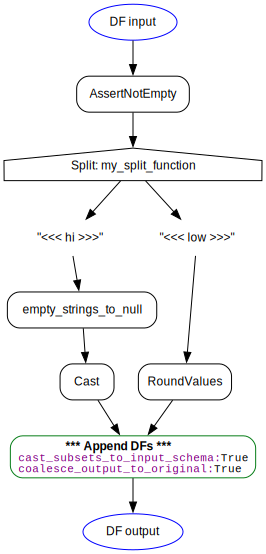

In [4]:
pipe.plot(add_params=False)

In [6]:
df_out = pipe.run(df_input, show_params=True)
print(df_out.schema)
df_out.sort("c1")

2025-12-25 02:25:04,856 | [INFO]: Starting pipeline 
2025-12-25 02:25:04,856 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-25 02:25:04,861 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-25 02:25:04,862 | [INFO]: Entering split: {'cast_subsets_to_input_schema': True, 'coalesce_output_to_original': True} 
2025-12-25 02:25:04,863 | [INFO]: Running 'empty_strings_to_null' ... 
2025-12-25 02:25:04,866 | [INFO]: Completed 'empty_strings_to_null' in 0.0s 
2025-12-25 02:25:04,867 | [INFO]: Running 'Cast' PARAMS: cast={'c1': 'float'} ... 
2025-12-25 02:25:04,868 | [INFO]: Completed 'Cast' in 0.0s 
2025-12-25 02:25:04,870 | [INFO]: Running 'RoundValues' PARAMS: column="c1", precision=1 ... 
2025-12-25 02:25:04,870 | [INFO]: Completed 'RoundValues' in 0.0s 
2025-12-25 02:25:04,870 | [INFO]: Pipeline completed in 0.0s 


Schema([('c1', Float64), ('c2', String), ('c3', String)])


c1,c2,c3
f64,str,str
0.1,"""a""","""b"""
4.1,"""""",""""""
5.1,null,null
6.1,"""""",null
8.1,"""a""",null
9.1,"""a""",""""""
10.1234,null,"""b"""
11.1234,"""a""",null
12.1234,null,"""b"""


## Create the same pipeline using yaml

In the `YAML` file, specify the split-function under the key `split_function`

The split-function must then be passed to the function `load_pipeline` as `extra_functions` value.
It can ben accomplished using a `list` (see the example) or a `dictionary` like:

`{"my_split_function": your-split-function}`

If a `list` is used, ensure that the function name aligns with the one specified in the `YAML` file.

Otherwise if a `dictionary` is used, the key must match the name in the `YAML` file, while the value can be any

In [ ]:
yml_data = """
name: "split-low-hi-values"
split_function: my_split_function  # name of you split function
pipeline:
     "low":
       - transformer: RoundValues
         params:
           "input_columns": "c1"
           "precision": 1
       - transformer: Cast
         params:
           "cast": { "c1": "float" }

     "hi":
       - transformer: RoundValues
         params:
           "input_columns": "c1"
           "precision": 3
       - transformer: EmptyStringToNull
         params:
           columns: ["c2", "c3"]
"""

pipe_cfg = yaml.safe_load(yml_data)


pipe = load_pipeline(
    pipe_cfg,
    extra_functions=[my_split_function]  # provide here you custom split function as <list> or <dict>
    # equivalent to extra_functions={"my_split_function": my_split_function} as long as the function name matches the function name in YAML
)

pipe.show_pipeline(add_transformer_params=True)

In [ ]:
pipe.run(df_input).show()

### Specific functionalities for split pipelines

- `split_apply_before_appending`:  Add transformer(s) at the end of each split before re-merging
- `split_cast_to_input_schema`:  Cast to input schema. Raise Assertion Error in case of column mismatching
- `repartition_output_to_original`:  Repartition to the input number of partitions after re-merging
- `coalesce_output_to_original`:  Repartition to the input number of partitions after re-merging

In [ ]:
pipe = TransformerPipeline(
    {"low": low_values, "hi": hi_values},
    name="split-low-hi-values",
    split_function=my_split_function,
    split_apply_before_appending=[Count()],  # Add transformer(s) at the end of each split before re-merging
    split_cast_to_input_schema=True,  # Cast to input schema. Raise Assertion Error in case of column mismatching
    repartition_output_to_original=True,  # Repartition to the input number of partitions after re-merging
    coalesce_output_to_original=False,  # Repartition to the input number of partitions after re-merging
)

pipe.show(add_params=True)

In [ ]:
pipe.plot()

In [ ]:
pipe.run(df_input).show()